# Image classification with Google's ViT and Hugging Face 🤗

<a name="start"></a>

##  🔖 Table of contents

1. In [A brief introduction to Vision Transfomer (ViT)](#intro) we will explore the core ideas that define a vision transformer model. 
<br><br>
2. In [Loading the data](#data) we will take advantage of the Hugging Face Hub and its libraries to download a cool dataset.
<br><br>
3. In [EDA with pandas](#eda) we will use pandas to explore the dataset.
<br><br>
4. In [Image pre-processing](#preprocess) we will learn how to pre-process the images for training.
<br><br>
5. In [Training](#train) we will fine-tune a pre-trained vision transformer to perform a down-stream task.
<br><br>
6. In [Evaluation](#eval) we will see how the model peforms after fine-tuning.
<br><br>
7. In [Data augmentation](#aug) we will add extra transformations to the pre-processing pipeline to make our model more robust to unseen data.
<br><br>
8. [Acknowledgments](#thanks) contains the main resources I used as a source of inspiration and learning to write this post.
<br><br>
9. [Additional resources](#more) contains extra materials that I highly recommend to check out.

<a name="intro"></a>

### ✨ A brief introduction to Vision Transfomer (ViT) ✨

> [Table of contents](#start)

The Vision Transformer (ViT) is a transformer-based architecture for computer vision tasks proposed in [An Image is Worth 16x16 Words](https://arxiv.org/pdf/2010.11929v2.pdf) paper by researchers at Google Brain in 2020. The ViT leverages only the encoder part of the original Transformer architecture and each input image is interpreted as a sequence of patch embeddings.

In the pre-processing phase an image is broken down into a grid of square patches. Each patch is flattened and linearly projected onto a lower-dimensional space. A learnable position embedding is then added to the resulting patch embedding to retain the positional information.
These steps are applied at once to each patch forming the image.

Before feeding the sequence of patch embeddings and position embeddings to the encoder, an extra learnable "class" embedding is prepended to the sequence. The last hidden state of this embedding serves as representation of the overall image. A classification head on top of the transformer encoder maps the last hidden state of the class embedding onto the final vector space representing the labels of the down-stream task.

In this notebook we will learn how to take a ViT model pre-trained on a large dataset and fine-tune it to perform image classification on a smaller task-specific dataset. We will use the [`google/vit-base-patch16-224-in21k` ](https://huggingface.co/google/vit-base-patch16-224-in21k) as a pre-trained model. This checkpoint was generated by pre-training a ViT on ImageNet-21k at a resolution of 224x224. During pre-processing images were converted into sequences of 16x16 patches. And as for the data, we will use the [`Matthijs/snacks`](https://huggingface.co/datasets/Matthijs/snacks) dataset which consists of 6745 images and 20 classes.

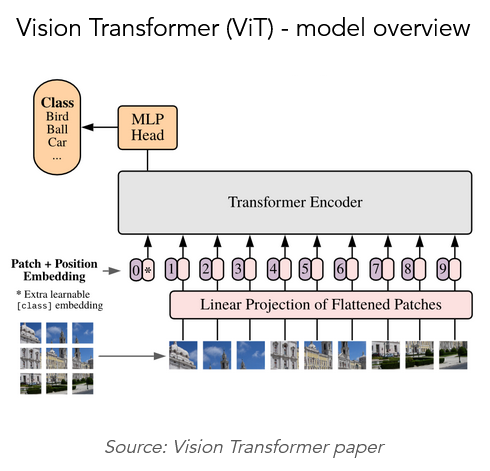

<a name="setup"></a>

### ✨ Setup ✨

> [Table of contents](#start)

We make sure our instance has a GPU and pip install the Hugging Face libraries.

In [ ]:
!nvidia-smi

Sun May 15 21:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# pip install libraries
!pip install datasets -Uqq
!pip install transformers[sentencepiece] -Uqq

     |████████████████████████████████| 342 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 39.1 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 136 kB 57.3 MB/s 
     |████████████████████████████████| 127 kB 54.4 MB/s 
     |████████████████████████████████| 271 kB 53.3 MB/s 
     |████████████████████████████████| 144 kB 53.4 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.2 MB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 42.5 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
     |████████████████████████████████| 1.2

In [ ]:
import numpy as np
import random
import torch

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed) 

set_seeds(2077)

<a name="data"></a>

### ✨ Loading the data ✨

> [Table of contents](#start)

We can conveniently get access to the dataset using the `load_dataset` function from the `datasets` library.

The resulting `DatasetDict` object already contains a train, validation and test set as `Dataset` objects. Each dataset has two features: `image` and `label`.

Images are `PIL.JpegImagePlugin.JpegImageFile` objects, whereas labels are simple integers.

We can inspect the content of a `Dataset` as if we were inspecting a normal `list`.

In [ ]:
# load dataset

from datasets import load_dataset

raw_data = load_dataset('Matthijs/snacks')
raw_data

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [ ]:
# inspect the first three samples
raw_data['train'][:3]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FF799067450>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=383x256 at 0x7FF799067A10>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x256 at 0x7FF70BFC9490>],
 'label': [5, 5, 5]}

We can get the full list of labels through the `features` attribute. They are represented as a `ClassLabel` object.

Each of the 20 labels represents a kind of snack... Some are healthier than others. 🍭

In [ ]:
# get labels

labels = raw_data['train'].features['label']
labels

ClassLabel(num_classes=20, names=['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon'], id=None)

Let's visualize some of the images with `matplotlib` to get a better understanding of the data. The `ClassLabel` class has a `int2str` method that allows us to map the IDs to the actual labels.

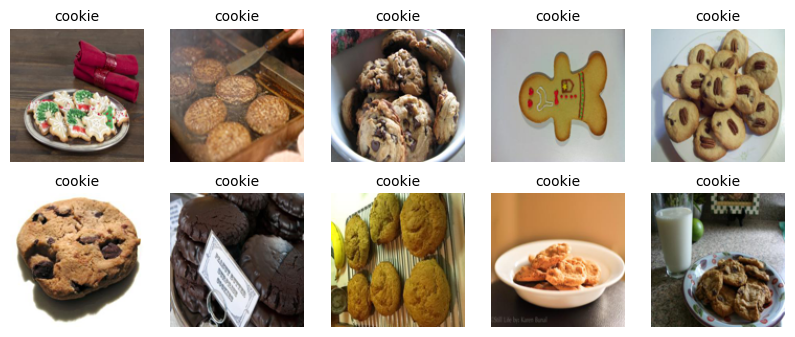

In [ ]:
# plot images

import matplotlib.pyplot as plt

nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(1, nrows*ncols + 1):
  sample_image = raw_data['train'][i]

  plt.subplot(nrows, ncols, i)
  plt.imshow(sample_image['image'].resize((128, 128)))
  plt.title(labels.int2str(sample_image['label']), fontsize=10)
  plt.axis('off')
plt.show()

Probably the reason why we visualized images representing only a single class is because the data is ordered by labels.

Let's plot some images once again, but this time using a random sample.

In [ ]:
# generate a random sample

random_sample = raw_data['train'].shuffle(seed=2077).select(range(100))

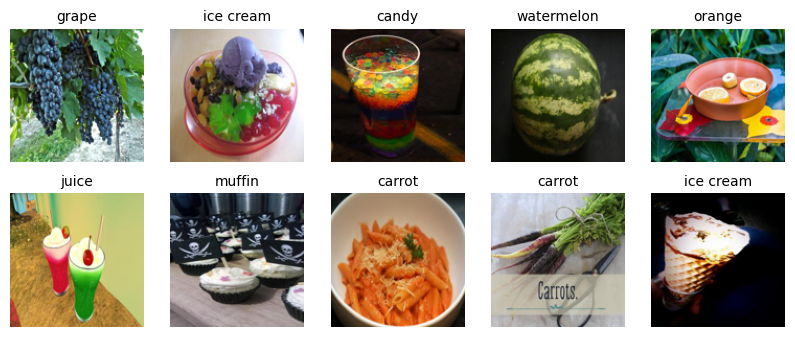

In [ ]:
# plot images

nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(nrows*ncols):
  sample_image = random_sample[i]

  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample_image['image'].resize((128, 128)))
  plt.title(labels.int2str(sample_image['label']), fontsize=10)
  plt.axis('off')
plt.show()

Now we're talking!

<a name="eda"></a>

### ✨ EDA with pandas ✨

> [Table of contents](#start)

The `DatasetDict` and `Dataset` classes offer the possibility to output the data as `pandas.DataFrame` object and investigate its content leveraging our knowledge of the `pandas` library.

We just need to change the output format with the `set_format` method and grab the data by slicing the entire dataset with `[:]`.

In [ ]:
raw_data.set_format('pandas')

raw_data_pd = raw_data['train'][:]
raw_data_pd.shape

(4838, 2)

We count the number of images available for each label to check if there is any imbalance. Then we visualize the result as a barplot using `seaborn`.

In [ ]:
# count number of images by label
samples_count = (
    raw_data_pd
    .groupby('label')
    .count()
    .reset_index()
    .rename(columns={'image': 'count'})
    # .reset_index()
)

# map IDs to labels
samples_count['label'] = samples_count['label'].map(lambda x: labels.int2str(x))

samples_count

label  count
0        apple    250
1       banana    250
2         cake    249
3        candy    249
4       carrot    249
5       cookie    249
6     doughnut    250
7        grape    250
8      hot dog    250
9    ice cream    250
10       juice    250
11      muffin    250
12      orange    249
13   pineapple    260
14     popcorn    180
15     pretzel    154
16       salad    250
17  strawberry    249
18      waffle    250
19  watermelon    250

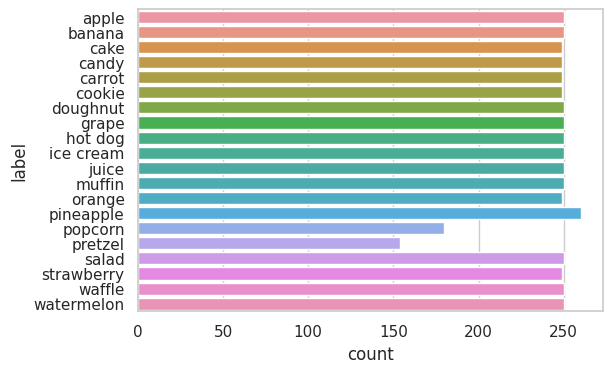

In [ ]:
import seaborn as sns

sns.set_theme(style='whitegrid', palette='pastel')
plt.figure(dpi=100)

bar = sns.barplot(y='label', x='count', data=samples_count, orient='h')

plt.show()

As we can observe from the table and bar plot above, most classes are represented by about 250 images. `pineapple` is the most common class with 260 images, whereas `pretzel` is the least represented class with only 154 images.

Overall, we can say this dataset is pretty well balanced.

Before moving to the next section, let's make sure to restore the original format of the data with the `reset_format` method.

In [ ]:
raw_data.reset_format()

<a name="preprocess"></a>

### ✨ Image pre-processing ✨

> [Table of contents](#start)

As for text, images also require some sort of pre-processing before they can be fed to a ViT.
The most basic  approach just requires resizing and normalizing the images across the channels with the same statistics used during pre-training.

We will see how to increase the robustness of our model with the help of data augmentation in a section below.

The Hugging Face library provides a `ViTFeatureExtractor` class that automatically performs resizing and normalization according to the pre-training statistics.

To load the pre-processing pipeline, sometimes referred as **feature extractor**, we simply pass the `google/vit-base-patch16-224-in21k` checkpoint as an argument to the `from_pretrained` method when instantiating the `ViTFeatureExtractor` object.

It specifies that images need to be resized at a resolution of 224x224 and normalized across channels using `image_mean` and `image_std` statistics.

In [ ]:
from transformers import ViTFeatureExtractor

checkpoint = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)
feature_extractor

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

We can test the feature extractor by simply passing a sample image as an argument.

What we get in return is a dictionary with a `pixel_values` key and associated value is a list that contains a `numpy.ndarray` of shape `3x224x224` representing the pre-processed image.

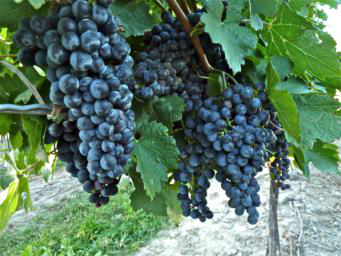

In [ ]:
# get a sample image
sample_image = random_sample['image'][0]
sample_image

In [ ]:
# preprocess sample image

sample_image_features = feature_extractor(sample_image)
sample_image_features

{'pixel_values': [array([[[-0.5294118 , -0.5294118 , -0.5137255 , ...,  0.18431377,
          0.16078436, -0.03529412],
        [-0.54509807, -0.5529412 , -0.5372549 , ..., -0.00392157,
          0.12156868,  0.12941182],
        [-0.56078434, -0.5686275 , -0.5686275 , ..., -0.05882353,
          0.05098045,  0.11372554],
        ...,
        [-0.30196077, -0.19215685,  0.07450986, ...,  0.37254906,
          0.2941177 ,  0.18431377],
        [-0.27843136, -0.23137254,  0.15294123, ...,  0.41176474,
          0.2941177 ,  0.3176471 ],
        [-0.23921567, -0.25490195, -0.01960784, ...,  0.5921569 ,
          0.30980396,  0.37254906]],

       [[-0.19215685, -0.19215685, -0.19215685, ...,  0.8039216 ,
          0.75686276,  0.5372549 ],
        [-0.20784312, -0.21568626, -0.21568626, ...,  0.5529412 ,
          0.654902  ,  0.64705884],
        [-0.23137254, -0.24705881, -0.24705881, ...,  0.39607847,
          0.48235297,  0.5294118 ],
        ...,
        [ 0.05882359,  0.15294123,  

In [ ]:
sample_image_features['pixel_values'][0].shape

(3, 224, 224)

We can visually inspect the pre-processed image by first converting the `numpy.ndarray` into a `torch.Tensor` and then convert the tensor into a `PIL.Image.Image` with the help of the `transforms.ToPILImage()` from the `torchvision` library.

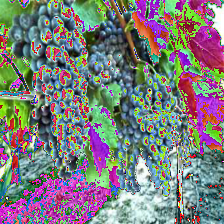

In [ ]:
# plot pre-processed image

from torchvision import transforms
import torch

transforms.ToPILImage()(torch.tensor(sample_image_features['pixel_values'][0]))

Now that we have a basic grasp of how the ViT feature extractor works, we can define a function that extract the `pixel_values` from each data point and apply this function on-the-fly on batches with the `set_transform` method everytime `__getitem__` is called.

We can use the `deepcopy` function from the `copy` library to duplicate the datasets and keep the original ones unaltered.

In [ ]:
# define function to generate augmented images

def apply_feature_extractor(examples):
  examples['pixel_values'] = [torch.tensor(feature_extractor(image.convert('RGB'))['pixel_values'][0]) for image in examples['image']]
  return examples

In [ ]:
# duplicate dataset and apply data augmentation
import copy

data_preprocessed = copy.deepcopy(raw_data)
data_preprocessed.set_transform(apply_feature_extractor)

data_preprocessed

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

To see the function at work we simply need to access a sample.

In [ ]:
data_preprocessed['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FF700ABDE50>,
 'label': 5,
 'pixel_values': tensor([[[ 0.0039,  0.0275,  0.0275,  ...,  0.7412,  0.7569,  0.7020],
          [ 0.0196, -0.0196, -0.0039,  ...,  0.7569,  0.7490,  0.6863],
          [-0.0431,  0.0980,  0.3176,  ...,  0.7490,  0.6549,  0.5608],
          ...,
          [-0.3333, -0.3255, -0.3098,  ..., -0.3020, -0.3647, -0.3725],
          [-0.3490, -0.3255, -0.3020,  ..., -0.3176, -0.3961, -0.3961],
          [-0.4118, -0.3569, -0.3176,  ..., -0.2941, -0.3647, -0.3569]],
 
         [[-0.3647, -0.3333, -0.3176,  ...,  0.7255,  0.7882,  0.7569],
          [-0.2863, -0.3255, -0.3020,  ...,  0.6784,  0.7098,  0.6863],
          [-0.2627, -0.1137,  0.1137,  ...,  0.5843,  0.5294,  0.4667],
          ...,
          [-0.4824, -0.4902, -0.4824,  ..., -0.6627, -0.6863, -0.6784],
          [-0.4980, -0.4745, -0.4667,  ..., -0.6627, -0.6941, -0.6863],
          [-0.5529, -0.4980, -0.4745,  ..., -0.6314, 

It seems to work properly. Everytime one or more samples are accessed, the pre-processing function is invoked to generate the `pixel_values` which are then added to the `features`.

Just to be 100% sure the pre-processing transformation is working in the right way, let's visualize a couple of images.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


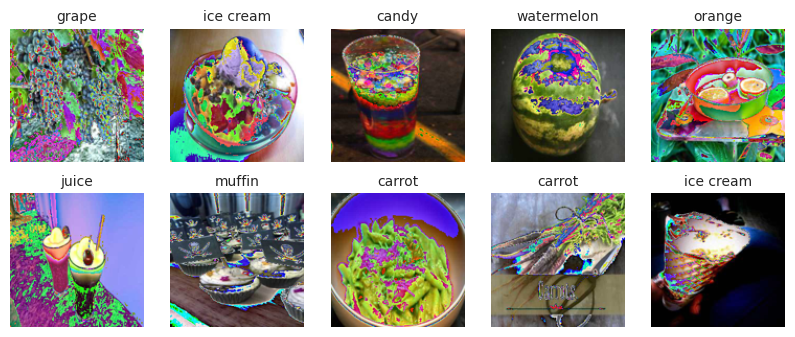

In [ ]:
# plot images

nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

preprocessed_samples = data_preprocessed['train'].shuffle(seed=2077).select(range(nrows * ncols))

for i in range(nrows*ncols):
  preprocessed_sample = preprocessed_samples[i]

  plt.subplot(nrows, ncols, i+1)
  plt.imshow(transforms.ToPILImage()(torch.tensor(preprocessed_sample['pixel_values'])).resize((128, 128)))
  plt.title(labels.int2str(preprocessed_sample['label']), fontsize=10)
  plt.axis('off')
  
plt.show()

It's looking good!

Before moving to the training phase, there is one last step we have to do: rename the `label` feature as `labels` because by default the model will look for this specific column to compute the loss.

In [ ]:
data_cleaned = data_preprocessed.rename_column('label', 'labels')
data_cleaned

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 955
    })
})

<a name="train"></a>

### ✨ Training ✨

> [Table of contents](#start)

We can get access to a pre-trained ViT model using the `ViTForImageClassification` class and use its `from_pretrained` method to load a pre-existing checkpoint.

In addition to the checkpoint, we also need to set `num_labels` to correctly represent the number of classes in our dataset.
In this way, during initialization the  `ViTForImageClassification` class will replace the default head with a new one intended for our down-stream dataset.

For the sake of completeness, in this specific example we also define the `id2label` and `label2id` parameters to map IDs to labels and vice versa, but they are totally optional and they are not as relevant as `num_labels`.

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=labels.num_classes,
    id2label={index: label for index, label in enumerate(labels.names)},
    label2id={label: index for index, label in enumerate(labels.names)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


By default the training loop reports back only the training and validation loss which from a human perspective can be difficult to interpret.

For this reason, we define a function to compute some of the metrics commonly used in a classification task: `accuracy`, `precision`, `recall` and `f1` score.

They are all available through the `load_metric` function from the `datasets` library.

We define a function that at each evaluation step will take the validation predictions as input and will report back the metrics we chose.

In [ ]:
import numpy as np
from datasets import load_metric

# define function to compute metrics
def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')

  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))

  return metrics

The `TrainingArguments` class from the `transformers` library is responsible for gathering up all the parameters to customize the training loop. The only required parameter is an `output_dir` to save predictions and checkpoints, but in this case we also specified parameters like the number of epochs, the batch size and how frequently we want to evaluate the model.

By default the `remove_unused_columns` is set to `True` so that during training the model automatically drops unwanted `features` like the `image` items in our dataset. However, we can't drop this feature yet because the `set_transform` method and the `apply_feature_extractor` function we defined earlier require the raw images to generate the `pixel_values` feature.

That's why we need to explicitly set this parameter to `False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='vit-run#0001',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_steps=200,
    logging_steps=200,
    evaluation_strategy='steps',
    eval_steps=200,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    fp16=True
)

The data collator is that piece of code responsible to assemble together individual samples into batches.
Since we instructed the training loop to keep all the features, we can't rely on the `DefaultDataCollator` from the `transformers` library anymore. During training it would attempt to feed to the model also the original images, but as we well know at this point, the ViT model only accepts `pixel_values` and `labels` as input features.

We can overcome the issue by defining our own collate function. During training and inference the collate function receives as input a list of data points. The length of the list is defined by the batch size.

In this specific example, a data point corresponds to a dictionary with three key-value pairs: `image`, `labels` and `pixel_values`. Knowing that, we define our custom collate function so that it only keeps `pixel_values` and `labels` and ignores `image`.

`pixel_values` are 3D (channels, height, width) tensors and therefore we bundle them together with `torch.stack` to form a 4D tensor representing batch size, channels, height and width. `labels` are just integers and it's sufficient to convert the list containing them into a `torch.tensor`.

In [ ]:
# examples is a list of dict where each dict represents a single example
# e.g. examples = [{'image': , 'labels': , 'pixel_values': }]

def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['labels'] for example in examples])
  return {'pixel_values': pixel_values, 'labels': labels}

We can test the custom collate function by providing a list of examples.

In this case we assume that a batch includes 8 samples.

In [ ]:
collate_test = collate_fn([data_cleaned['train'][i] for i in range(8)])
print(collate_test['pixel_values'].shape)
print(collate_test['labels'])

torch.Size([8, 3, 224, 224])
tensor([5, 5, 5, 5, 5, 5, 5, 5])


It returned what we were expecting and so we're good to move on!

The `Trainer` class from the `transformers` library is the training loop itself. We provide all the items we've generated so far:
- pre-trained model
- training arguments
- custom collate function
- training and validation dataset
- custom metrics function

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    data_collator=collate_fn,
    train_dataset=data_cleaned['train'],
    eval_dataset=data_cleaned['validation'],
    compute_metrics=compute_metrics_fn
)

Using amp half precision backend


The `train` method starts the training process.

> 💡 It is completely fine to get different numbers from one iteration to another.


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4838
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1515


***** Running Evaluation *****
  Num examples = 955
  Batch size = 16


Saving model checkpoint to vit-run#0001/checkpoint-200
Configuration saved in vit-run#0001/checkpoint-200/config.json
Model weights saved in vit-run#0001/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0001/checkpoint-400
Configuration saved in vit-run#0001/checkpoint-400/config.json
Model weights saved in vit-run#0001/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0001/checkpoint-600
Configuration saved in vit-run#0001/checkpoint-600/config.json
Model weights saved in vit-run#0001/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0001/checkpoint-800
Configuration saved in vit-run#0001/checkpoint-800/config.json
Model weights saved in vit-run#0001/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examp

TrainOutput(global_step=1515, training_loss=0.48840886326906313, metrics={'train_runtime': 686.8561, 'train_samples_per_second': 35.218, 'train_steps_per_second': 2.206, 'total_flos': 1.874833643725701e+18, 'train_loss': 0.48840886326906313, 'epoch': 5.0})

<a name="eval"></a>

### ✨ Evaluation ✨

> [Table of contents](#start)

The metrics computed for the validation set during training looks promising.

Let's evaluate our fine-tuned ViT on the test set.

In [ ]:
trainer.evaluate(data_cleaned['test'])

***** Running Evaluation *****
  Num examples = 952
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.9474789915966386,
 'eval_f1': 0.9474429843392228,
 'eval_loss': 0.25897082686424255,
 'eval_precision': 0.9481391625741377,
 'eval_recall': 0.9474789915966386,
 'eval_runtime': 12.0318,
 'eval_samples_per_second': 79.124,
 'eval_steps_per_second': 4.987}

We can assume as a simple baseline the accuracy achieved by a hypothetical model that always predicts the most common class in the training set. Since in our case the most represented class is `pineapple` with 260 images and the train set overall contains 4,838 images, with this heuristic we would achieve an train accuracy of about 5.37%.

With the test accuracy well above 90% our fine-tuned ViT is definitely outperforming the baseline and in a real-world scenario it would justify its deployment in production.

We can get a better understanding of the results with the help of a classification report and confusion matrix both from `sklearn`.

Before doing that, we need to write a function to score each data point and generate the final predictions. First we leverage the `predict` method of the `Trainer` class to obtain the logits and then we use `numpy.argmax` to find the index corresponding to the largest logit.

That index represents the predicted class.

In [ ]:
# define fuction to convert logits into label IDs

def get_predictions(dataset, model):
  raw_preds = model.predict(dataset)
  logits = raw_preds.predictions
  targets = raw_preds.label_ids
  preds = np.argmax(logits, axis=-1)

  return (targets, preds)

# get indexes and target labels
targets, preds = get_predictions(data_cleaned['test'], trainer)

***** Running Prediction *****
  Num examples = 952
  Batch size = 16


In [ ]:
# print out classificatio report

from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=labels.names))

              precision    recall  f1-score   support

       apple       0.98      0.96      0.97        50
      banana       0.94      1.00      0.97        50
        cake       0.87      0.90      0.88        50
       candy       0.98      0.92      0.95        50
      carrot       0.96      0.94      0.95        50
      cookie       0.98      0.94      0.96        50
    doughnut       0.91      1.00      0.95        50
       grape       1.00      0.98      0.99        50
     hot dog       0.94      0.98      0.96        50
   ice cream       0.96      0.92      0.94        50
       juice       0.94      0.98      0.96        50
      muffin       0.86      0.92      0.89        48
      orange       0.94      0.94      0.94        50
   pineapple       0.91      0.97      0.94        40
     popcorn       0.97      0.95      0.96        40
     pretzel       0.96      0.92      0.94        25
       salad       0.90      0.90      0.90        50
  strawberry       0.95    

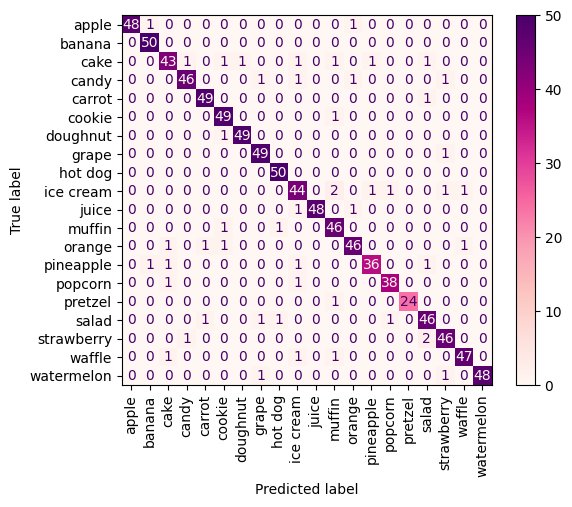

In [ ]:
# plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc_file_defaults()
fig, ax = plt.subplots(dpi=100)
label_font = {'size':'18'}  # Adjust to fit


ConfusionMatrixDisplay.from_predictions(
    targets,
    preds,
    display_labels=labels.names,
    cmap='RdPu',
    ax=ax
)

plt.xticks(rotation=90)

plt.show()

<a name="aug"></a>

### ✨ Data augmentation ✨

> [Table of contents](#start)

Previously, we've learned how to pre-process the images with the standard feature extractor imported from Hugging Face.

In this section we will learn how to replace it with a customized pre-processing pipeline that will include additional transformations to increase the variety of images we will present to the model.

Those augmented images will make our model more robust to examples never encountered during training.

For this example we will rely on the transformations available in `torchvision.transforms`.

In addition to `Normalize` and `ToTensor` which were already present in the `ViTFeatureExtractor` class, we add to our customized pre-processing pipeline `RandomResizedCrop`, which replaces the standard resizing step, `RandomHorizontalFlip` and `RandomAdjustSharpness`. During training, these transformations will have a chance to crop, horizontally split images and change their sharpness.

These are just a few of the transformations available in `torchvision.transforms` and with a similar logic it is possible to integrate transformations from other libraries, such as `albumentations`.

It is the task at hand that defines which transformations are worth including because with data augmentation we don't want to blindly increase the variety of the dataset. We also need to make sure that the augmented samples are plausible images that the model might have a chance to encounter once in production. For example, if we are trying to build a model to classify images of cars, probably applying a vertical flip is not the best option because in normal condition images of upside down cars are not that common. A horizontal flip might be a more suitable option.

In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    ToTensor,
    ToPILImage
)

When it comes to data augmentation, the dominant approach requires that random transformations are only applied to the train data, whereas the validation and test sets are subject to deterministic augmentations. In doing so, during each epoch the model has a chance to be exposed to slightly different images, but in the evaluation step the model is always scored against the same set of images.

For this example we will follow this strategy.

For resizing and normalization we need to make sure we align with the values used in the feature extractor. We can access the exact numbers through the `size`, `image_mean` and `image_std` attributes.

For all the random transformation, we set the probability of being applied to 0.5.

Finally, we can chain all those transformations together with `Compose`.

In [ ]:
# data augmentation transformations

# train
train_aug_transforms = Compose([
    RandomResizedCrop(size=feature_extractor.size),
    RandomHorizontalFlip(p=0.5),
    RandomAdjustSharpness(sharpness_factor=5, p=0.5),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# validation/test
valid_aug_transforms = Compose([
    Resize(size=(feature_extractor.size, feature_extractor.size)),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

Let's check both pre-processing pipelines on the sample image we defined earlier.

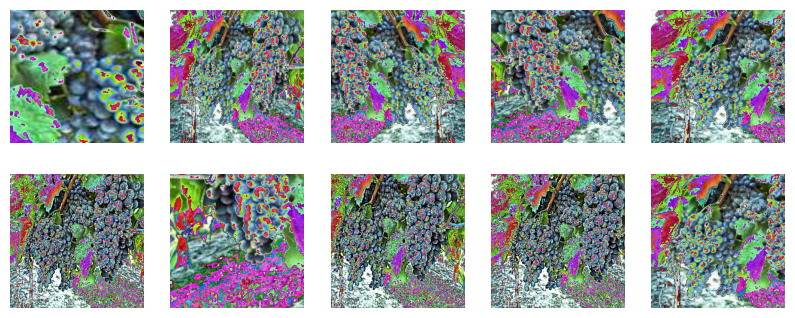

In [ ]:
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(1, nrows*ncols + 1):
  plt.subplot(nrows, ncols, i)
  plt.imshow(ToPILImage()(train_aug_transforms(sample_image)))
  plt.axis('off')
plt.show()

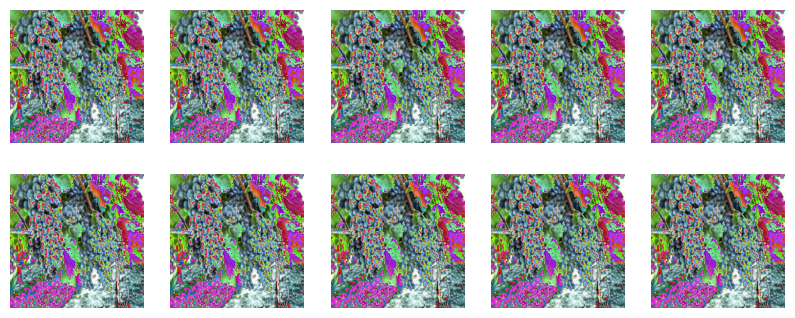

In [ ]:
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(1, nrows*ncols + 1):
  plt.subplot(nrows, ncols, i)
  plt.imshow(ToPILImage()(valid_aug_transforms(sample_image)))
  plt.axis('off')
plt.show()

They both seem to work as expected: the train pipeline produced slightly different variations of the same image, whereas the validation/test pipeline generated the same output at each iteration.

Since we have two distinct transformation pipelines, we need to define two distinct functions as well. Then we pass them to each dataset independently with the `set_transform` method.

In [ ]:
# define function to generate augmented images

def apply_train_aug_transforms(examples):
  examples['pixel_values'] = [train_aug_transforms(img.convert('RGB')) for img in examples['image']]
  return examples

def apply_valid_aug_transforms(examples):
  examples['pixel_values'] = [valid_aug_transforms(img.convert('RGB')) for img in examples['image']]
  return examples

In [ ]:
data_preprocessed['train'].set_transform(apply_train_aug_transforms)
data_preprocessed['validation'].set_transform(apply_valid_aug_transforms)
data_preprocessed['test'].set_transform(apply_valid_aug_transforms)
data_preprocessed

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

Just to be 100% sure everything went well, let's visualize the outputs one last time.

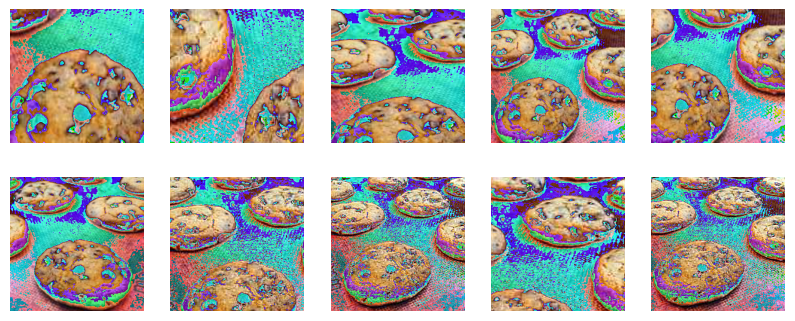

In [ ]:
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(1, nrows*ncols + 1):
  plt.subplot(nrows, ncols, i)
  plt.imshow(ToPILImage()(data_preprocessed['train'][0]['pixel_values']))
  plt.axis('off')
plt.show()

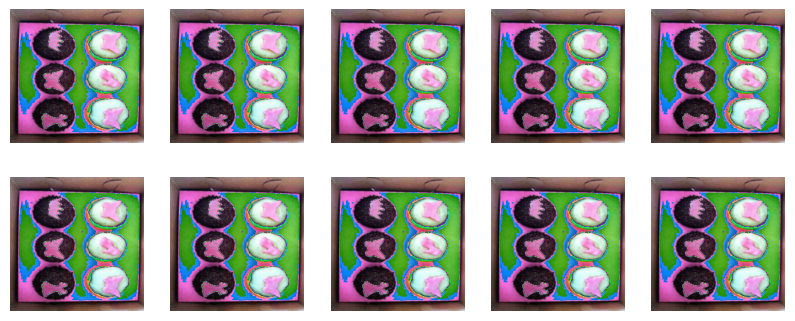

In [ ]:
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2), dpi=100)

for i in range(1, nrows*ncols + 1):
  plt.subplot(nrows, ncols, i)
  plt.imshow(ToPILImage()(data_preprocessed['test'][0]['pixel_values']))
  plt.axis('off')
plt.show()

Everything is looking good!

In [ ]:
data_cleaned = data_preprocessed.rename_column('label', 'labels')
data_cleaned

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 955
    })
})

#### Training

> [Table of contents](#start)

As for the training nothing will change.

In [ ]:
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=labels.num_classes,
    id2label={index: label for index, label in enumerate(labels.names)},
    label2id={label: index for index, label in enumerate(labels.names)}
)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='vit-run#0002',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_steps=200,
    logging_steps=200,
    evaluation_strategy='steps',
    eval_steps=200,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    fp16=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    data_collator=collate_fn,
    train_dataset=data_cleaned['train'],
    eval_dataset=data_cleaned['validation'],
    compute_metrics=compute_metrics_fn
)

Using amp half precision backend


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4838
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1515


***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0002/checkpoint-200
Configuration saved in vit-run#0002/checkpoint-200/config.json
Model weights saved in vit-run#0002/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0002/checkpoint-400
Configuration saved in vit-run#0002/checkpoint-400/config.json
Model weights saved in vit-run#0002/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0002/checkpoint-600
Configuration saved in vit-run#0002/checkpoint-600/config.json
Model weights saved in vit-run#0002/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
Saving model checkpoint to vit-run#0002/checkpoint-800
Configuration saved in vit-run#0002/checkpoint-800/config.json
Model weights saved in vit-run#0002/check

TrainOutput(global_step=1515, training_loss=0.7456918596827945, metrics={'train_runtime': 685.1737, 'train_samples_per_second': 35.305, 'train_steps_per_second': 2.211, 'total_flos': 1.874833643725701e+18, 'train_loss': 0.7456918596827945, 'epoch': 5.0})

#### Evaluation

> [Table of contents](#start)

Let's see how the model performs on the test set.

In [ ]:
trainer.evaluate(data_cleaned['test'])

***** Running Evaluation *****
  Num examples = 952
  Batch size = 16


{'eval_accuracy': 0.944327731092437,
 'eval_f1': 0.9442795351899795,
 'eval_loss': 0.3101879954338074,
 'eval_precision': 0.945520405649697,
 'eval_recall': 0.944327731092437,
 'eval_runtime': 12.514,
 'eval_samples_per_second': 76.075,
 'eval_steps_per_second': 4.795}

Even though this second model achieves a slightly lower test accuracy, it is probably more robust than the previous one thanks to the augmented images.

It's also important to notice that at the end of this second run the training loss is still larger than the validation loss. This might be a sign that the model is underfitting the training set and there might still be room for improvement by training for additional epochs.

In [ ]:
# get indexes and target labels
targets, preds = get_predictions(data_cleaned['test'], trainer)

***** Running Prediction *****
  Num examples = 952
  Batch size = 16


In [ ]:
# print out classificatio report

from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=labels.names))

              precision    recall  f1-score   support

       apple       0.98      0.96      0.97        50
      banana       0.94      1.00      0.97        50
        cake       0.87      0.90      0.88        50
       candy       0.98      0.92      0.95        50
      carrot       0.96      0.94      0.95        50
      cookie       0.98      0.94      0.96        50
    doughnut       0.91      1.00      0.95        50
       grape       1.00      0.98      0.99        50
     hot dog       0.94      0.98      0.96        50
   ice cream       0.96      0.92      0.94        50
       juice       0.94      0.98      0.96        50
      muffin       0.86      0.92      0.89        48
      orange       0.94      0.94      0.94        50
   pineapple       0.91      0.97      0.94        40
     popcorn       0.97      0.95      0.96        40
     pretzel       0.96      0.92      0.94        25
       salad       0.90      0.90      0.90        50
  strawberry       0.95    

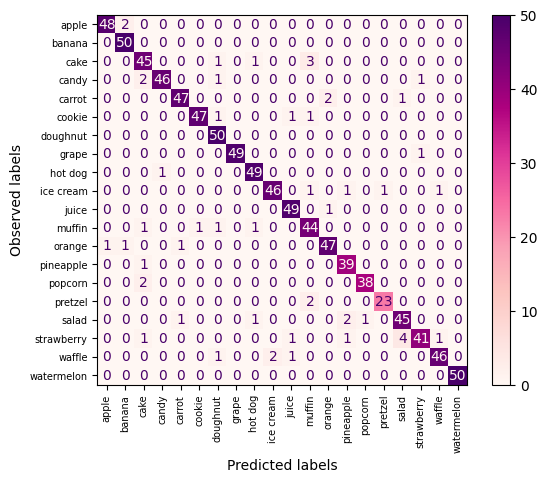

In [ ]:
# plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc_file_defaults()
fig, ax = plt.subplots(dpi=100)


ConfusionMatrixDisplay.from_predictions(
    targets,
    preds,
    display_labels=labels.names,
    cmap='RdPu',
    ax=ax
)

label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('Observed labels', fontdict=label_font)
ax.tick_params(axis = 'both', labelsize=7)

plt.xticks(rotation=90)

plt.show()

<a name="end"></a>

### ✨ Conclusion ✨

> [Table of contents](#start)

In this post we've learned that the ViT is an encoder-based architecture designed to perform computer vision tasks. One of the most interesting aspects is how images are pre-processed and fed to the model: each image is divided into 16x16 patches and those patches are transformed into a sequence of embeddings to form the input data.

Then we've discovered how to take a pre-trained model from Hugging Face and fine-tune it to perform image classification on a task-specific dataset.

Finally we've learned how to enhance the default pre-processing pipeline with additional data augmentation transformations to fine-tune a more performing and robust model.

<a name="thanks"></a>

### 🤗 Acknowledgments 🤗

> [Table of contents](#start)

- A big shout out to the Hugging Face community. In particular, I would like to personally thank [Niels Rogge](https://twitter.com/NielsRogge) and [Nate Raw](https://twitter.com/_nateraw) for their contributions to the broader community. [Niels' notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb) and [Nate's post](https://huggingface.co/blog/fine-tune-vit#evaluate-%F0%9F%93%8A) were fundamental sources of inspiration to write this blog post. A special thanks also to [Matthijs Hollemans](https://twitter.com/mhollemans) for making available the [snacks](https://huggingface.co/datasets/Matthijs/snacks) dataset on the Hub.
<br><br>
- [Sergios Karagiannakos](https://twitter.com/KarSergios)' [ViT tutorial](https://theaisummer.com/hugging-face-vit/) was another great source of knowledge and inspiration.





<a name="more"></a>

### 📚 Additional resources 📚

> [Table of contents](#start)

- The [ViT paper](https://arxiv.org/pdf/2010.11929v2.pdf) and [Google AI's blog post](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html) are two great resources to explore more in depth the theory behind the ViT.
<br><br>
- If you prefer videos over articles, then [Yannic Kilcher's ViT paper explanation](https://www.youtube.com/watch?v=TrdevFK_am4&ab_channel=YannicKilcher) might be the right resource for you to learn more about the ViT architecture.
<br><br>
- The Hugging Face [Course](https://huggingface.co/course/chapter1/1) and [Docs](https://huggingface.co/docs) are the go-to resources to clarify doubts and learn more about the Hugging Face libraries in general.
